---
title: "Feature Selection for Text Data"
format:
    html:
        page-layout: full
        code-fold: show
        code-copy: true
        code-tools: true
        code-overflow: wrap
---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from ast import literal_eval
os.chdir('/Users/samanthamoon/Desktop/DSAN 5000/dsan-5000-project-samjmoon/dsan-website/5000-website/data-cleaning')
movies_df = pd.read_csv('movies_metadata.csv')
movies_df['genres'] = movies_df['genres'].apply(lambda x: [genre['name'] for genre in literal_eval(x)] if isinstance(x, str) else [])
movies_df.head()

/var/folders/mm/79b3ggcn52x9kcrnqfx5mtk40000gn/T/ipykernel_60159/3921302380.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


<br>
I will reduce the movie_df into a smaller dataframe called text_df which will include columns “original_title”, “overview”, and “genres”. I will proceed to clean the text data via lowercasing and removing punctuation.
<br>
<br>

In [2]:
text_df = movies_df[['original_title', 'overview', 'genres']]
text_df = text_df.head(5000)
text_df['original_title'] = text_df['original_title'].str.lower()
text_df['overview'] = text_df['overview'].str.lower()
text_df['overview'] = text_df['overview'].astype(str)
text_df['original_title'] = text_df['original_title'].astype(str)
import string
def remove_punctuations(text):
    return ' '.join(word.strip(string.punctuation) for word in text.split())

text_df['overview'] = text_df['overview'].apply(remove_punctuations)
text_df.head()

,original_title,overview,genres
0,toy story,led by woody andy's toys live happily in his r...,"[Animation, Comedy, Family]"
1,jumanji,when siblings judy and peter discover an encha...,"[Adventure, Fantasy, Family]"
2,grumpier old men,a family wedding reignites the ancient feud be...,"[Romance, Comedy]"
3,waiting to exhale,cheated on mistreated and stepped on the women...,"[Comedy, Drama, Romance]"
4,father of the bride part ii,just when george banks has recovered from his ...,[Comedy]


In [3]:
text_df = text_df.explode('genres')
text_df.reset_index(drop=True, inplace=True)
text_df['genres'] = text_df['genres'].astype(str)
text_df.head()

,original_title,overview,genres
0,toy story,led by woody andy's toys live happily in his r...,Animation
1,toy story,led by woody andy's toys live happily in his r...,Comedy
2,toy story,led by woody andy's toys live happily in his r...,Family
3,jumanji,when siblings judy and peter discover an encha...,Adventure
4,jumanji,when siblings judy and peter discover an encha...,Fantasy


I have exploded the “genres” column so that every row is attributed to one genre only.

In [4]:
#listing all genres
unique_strings = text_df['genres'].unique()
print(unique_strings)

['Animation' 'Comedy' 'Family' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'History' 'Science Fiction'
 'Mystery' 'War' 'Foreign' 'nan' 'Music' 'Documentary' 'Western'
 'TV Movie']


In [5]:
#assigning unique numbers to each genre for classification purposes
numbers = {string: number for number, string in enumerate(set(unique_strings))}
print(numbers)

text_df['category'] = text_df['genres'].map(numbers)
text_df.drop(columns=['genres'], inplace=True)
text_df.head()

{'Animation': 0, 'Adventure': 1, 'History': 2, 'Comedy': 3, 'Music': 4, 'Foreign': 5, 'War': 6, 'Fantasy': 7, 'Documentary': 8, 'Science Fiction': 9, 'TV Movie': 10, 'Mystery': 11, 'Family': 12, 'Western': 13, 'Drama': 14, 'nan': 15, 'Horror': 16, 'Crime': 17, 'Thriller': 18, 'Romance': 19, 'Action': 20}


,original_title,overview,category
0,toy story,led by woody andy's toys live happily in his r...,0
1,toy story,led by woody andy's toys live happily in his r...,3
2,toy story,led by woody andy's toys live happily in his r...,12
3,jumanji,when siblings judy and peter discover an encha...,1
4,jumanji,when siblings judy and peter discover an encha...,7


<br>
Some movies are categorized into multiple genres. To simplify my model, I will remove duplicated rows so that movies do not appear more than once in my dataset. This means the dataset I will be applying feature selection to will only reflect one category per movie. For the purpose of this task, I will work with one category per movie for simplicity.
<br>
<br>

In [6]:
text_df = text_df.drop_duplicates(subset=['original_title'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(text_df['overview'], text_df['category'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

k_best = 1000
selector = SelectKBest(chi2, k=k_best)
X_train_selected = selector.fit_transform(X_train_vectorized, y_train)
X_test_selected = selector.transform(X_test_vectorized)

nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)
y_pred = nb_model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, y_pred))

Accuracy: 0.31717171717171716
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00         6
           3       0.49      0.26      0.34       254
           4       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        15
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         8
          14       0.29      0.94      0.44       263
          15       0.00      0.00      0.00        19
          16       0.00      0.00      0.00        50
          17       0.00      0.00      0.00        46
          18       0.00      0.00      0.00        

/Users/samanthamoon/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samanthamoon/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samanthamoon/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross Validation ##

In [8]:
cv_scores = cross_val_score(nb_model, X_train_vectorized, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.3270202  0.33585859 0.33712121 0.32996207 0.32616941]
Mean CV accuracy: 0.33122629582806573


/Users/samanthamoon/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


From my cross-validation results, I’ve observed that the mean accuracy across all folds is approximately 33.12%. This value represents the average performance of my model across different subsets of the data. The individual accuracy scores for each subset range from around 32.62% to 33.71%. These scores provide a look into the variability of the model’s performance across different subsets of the data. The relatively small variation in individual scores suggests a consistent performance across different subsets. Consistency is desirable, as it indicates the model is not overly sensitive to the specific training and validation sets. The overall accuracy is on the lower side, which suggests that the model may face challenges in accurately predicting the target variable based on the features used.

## Confusion Matrix ##

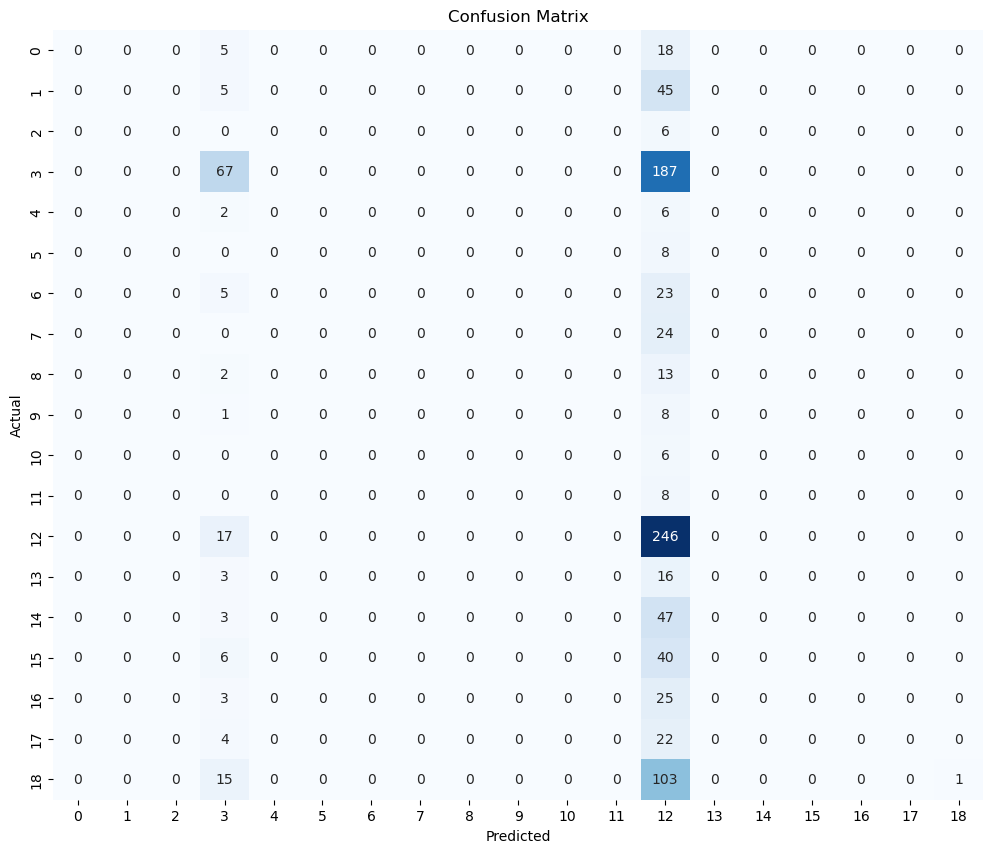

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Conclusion ##

In conclusion, the application of feature selection and the Naive Bayes classifier to the text data has provided valuable insights into the model’s performance. The utilization of the chi-squared test for feature selection, specifically selecting the top k features, demonstrated its impact on the overall accuracy of the Naive Bayes classifier. The cross-validation results, with a mean accuracy of approximately 33.12%, highlight the model’s consistent but modest predictive capabilities across different subsets of the data.

While the chosen features contribute to a more interpretable and efficient model, there remains room for improvement in predictive accuracy. The lower overall accuracy suggests that the current model may face challenges in capturing the complexities of the text data and accurately classifying documents into the specified categories. Further exploration may involve experimenting with different values of k in feature selection, considering alternative feature extraction techniques, or exploring more sophisticated text classification models to enhance predictive performance.

It is crucial to acknowledge the context-specific nature of text data, where nuances in language and context can significantly impact model performance. Additional evaluation metrics, such as precision, recall, and F1-score, could provide a more detailed understanding of the model’s strengths and weaknesses, especially in the presence of imbalanced classes or specific class priorities.

In summary, the feature selection and Naive Bayes approach offer a foundational framework for text classification, but ongoing refinement and exploration of advanced techniques may be necessary to achieve higher predictive accuracy in this complex and context-rich domain.